In [6]:
import numpy as np
import matplotlib.pyplot as plt
from docutils.nodes import figure
from sympy.printing.pretty.pretty_symbology import line_width

# Time Value of Money Under Uncertainty
## A Monte Carlo Approach Using Probability Theory and Numerical Simulation
## Scientific Method Approach

# 1. Observation

In classical financial theory, the Net Present Value (NPV) of a project is computed using deterministic future cash flow.

However, in real-world financial planning and analysis, future cash flow are uncertain and depend on economic conditions, demand variability and operation performance.

This raises the question: how should project valuation change when cash flow are random?


## 2. Research Question

If future cash flows are random variables instead of fixed numbers,
how does this affect the mathematical nature of Net Present Value ( NPV ) ?

Specifically:

* Does NPV become random variable
* What are its expected value variance?
* How can we approximate its distribution using simulation?

## 3. Hypothesis

If each cash flow $$ ( CF_t ) $$ is modeled as a random variable, then:

$$ NPV = \sum_{t=0}^{T} \frac{CF_t}{(1+r)^t} $$

is a linear combination of random variables.

Therefore:

• NPV is itself a random variable.
• It has a well-defined expected value.
• It has a measurable variance (risk).
• Its distribution can be approximated numerically using Monte Carlo simulation.

## 4. Deterministic Mathematical Model

In classical Time Value of Money, capital grows exponentially under compound interest.

If an initial investment $( P )$ grows at rate $(r)$ for $(t)$ periods:

$$ FV = P(1+r)^t $$

Solving for present value:

$$ PV = \frac{FV}{(1+r)^t} $$

Thus, discounting is the inverse operation of exponential growth

### Implementation Strategy and Numerical Example

The deterministic formulas derived above are now implemented in Python
These function will later serve as the core building blocks for the [stochastic extention.](https://en.wikipedia.org/wiki/Stochastic_process)

We verify the deterministic TVM formulas using a simple example.

* Initial Investment: 1000
* Interest Rate: 3%
* Time Horizon: 3 years

In [7]:
def future_value(p, r, t):
    return p * (1+r) ** t

def present_value(fv, r, t):
    return fv / (1+r) ** t

p = 1000
r = 0.05
t = 3

FV = future_value(p,r,t)
PV = present_value(FV, r, t)
PV_recovered = present_value(FV, r, t)

print("Future Value: ", FV)
print("Present Value: ", PV)
print("Recovered Value: ", PV_recovered)
print("Numerical Error:", abs(PV - PV_recovered))


Future Value:  1157.6250000000002
Present Value:  1000.0000000000001
Recovered Value:  1000.0000000000001
Numerical Error: 0.0


### Exponential Growth Visualization

To build intuition for compound interest, we visualize the future value function:

$$ FV(t) = P(1+r)^t $$

This function represents exponential growth. Unlike linear growth, the rate of increase accelerates over time because interest is earned on accumulated interest.

Understanding this curvature is important before introduction uncertainty, since longer time horizons amplify both expected returns and potential risk.

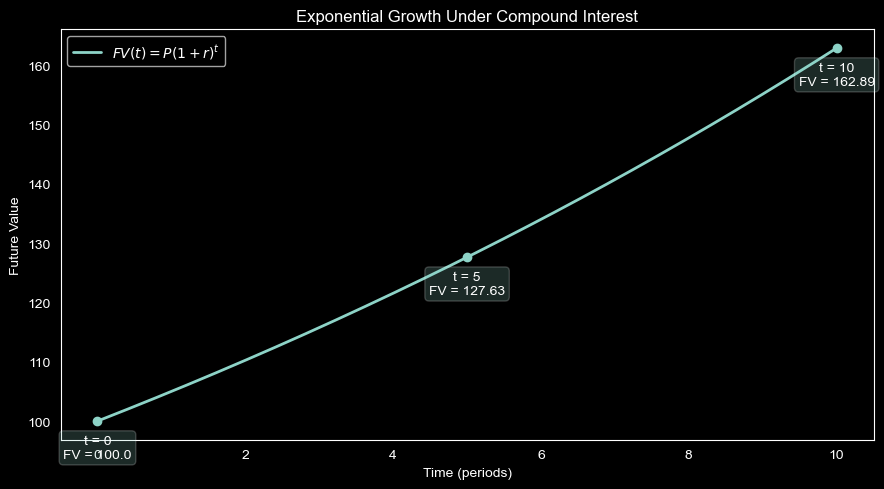

In [8]:
t_values = np.linspace(0, 10, 200)
P = 100
r = 0.05

growth = future_value(P, r, t_values)

plt.figure(figsize=(9, 5))
plt.plot(t_values, growth, linewidth=2, label=r"$FV(t)=P(1+r)^t$")

# Highlight a few key points for intuition
key_t = np.array([0, 5, 10])
key_fv = future_value(P, r, key_t)
plt.scatter(key_t, key_fv, zorder=3)

for i in range(len(key_t)):
    tt = key_t[i]
    ff = key_fv[i]

    plt.annotate(
        "t = " + str(tt) + "\nFV = " + str(round(ff, 2)),
        xy=(tt, ff),
        xytext=(0, -10),   # move text below point
        textcoords="offset points",
        ha="center",
        va="top",
        bbox=dict(boxstyle="round,pad=0.3", alpha=0.2)
    )

plt.title("Exponential Growth Under Compound Interest")
plt.xlabel("Time (periods)")
plt.ylabel("Future Value")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.grid(None)
plt.show()

## 5. Stochastic Cash Flows (Triangular Model)

In practise, future cash flows are uncertain.
Instead of assuming single deterministic value for each period, we model cash flows as random variables.

In financial planning and analysis a common assumption is the **triangular distribution**, defined by:

* Minimum value ( worst case )
* Most likely value ( base case )
* Maximum value ( best case )

This distribution reflects managerial forecast more realistically than assuming symmetrical normal uncertainty.

The triangular distribution is especially useful when:

* Historical data is limited
* Expert judgment is available
* Forecast ranges are defined

This makes it suitable for capital budgeting applications.

Let the cash flow in period $(t)$ follow:

$$ CF_t \sim Triangular(a_t, m_t, b_t) $$

where:
- $(a_t)$ = minimum
- $(m_t)$ = most likely
- $(b_t)$ = maximum

Since NPV is a weighted sum of these random variables:

$$ NPV = \sum_{t=0}^{T} \frac{CF_t}{(1+r)^t} $$

Net Present Value (NPV) becomes variable itself.

### Deterministic NPV Function

We implement a reusable function for computing NPV from a list of cash flows. This function will later be reused in Monte Carlo simulations.

In [9]:
def npv_from_cashflows(cashflows, r):
    total = 0.0
    for t in range(len(cashflows)):
        total  += cashflows[t] / (1 + r) ** t
    return total

## Function test

We test the function using a simple deterministic example.

In [10]:
cashflows_test = np.array([-1000, 400, 400, 4000])
r = 0.05

npv_from_cashflows(cashflows_test, r)

np.float64(3199.114566461505)


### Sampling One Triangular Cash Flow Scenario

NumPy provides a triangular distribution sampler:

np.random.triangular(left, mode, right)

We generate one simulated project cash flow path.

In [11]:
def sample_triangular_cashflows(a, m, b):
    cashflows = []
    for t in range(len(a)):
        if a[t] == m[t] == b[t]:
            cf = a[t]
        else:
            cf = np.random.triangular(a[t], m[t], b[t])
        cashflows.append(cf)
    return cashflows

### Example: Single Simulated Scenario

In [12]:
a = [-1000, 300, 300, 300]
m = [-1000, 400, 400, 400]
b = [-1000, 500, 500, 500]

sample_triangular_cashflows(a,m,b)

[-1000, 427.58227988864576, 354.1187738764871, 380.198159153277]

### Interpretation of the Simulated Scenario

The output represents one possible realization of the project's cash flow:
$ [-1000,\; 435.74,\; 360.22,\; 386.82] $

Interpretation:

* The initial investments $ (CF_0 = -1000) $ is deterministic (know with certainty).
* The future cash flows $ (CF_1, CF_2, CF_3)$ are randomly sampled  from their respective triangular distributions.
* Each run of the function produces a different scenario, reflecting uncertainty in future performance.

This single scenario represent one possible economic outcome.
To understand the full risk profile of the project, we must generate many such scenarios using Monte Carlo simulation.

### Visualizing the Triangular Distribution

To better understand the uncertainty model, we visualize the triangular distribution for one forecast period.

This shows:

* Minimum value ( worst case )
* Most likely value ( base case )
* Maximum value ( best case )

The shape of the distribution depends on the location of the mode.


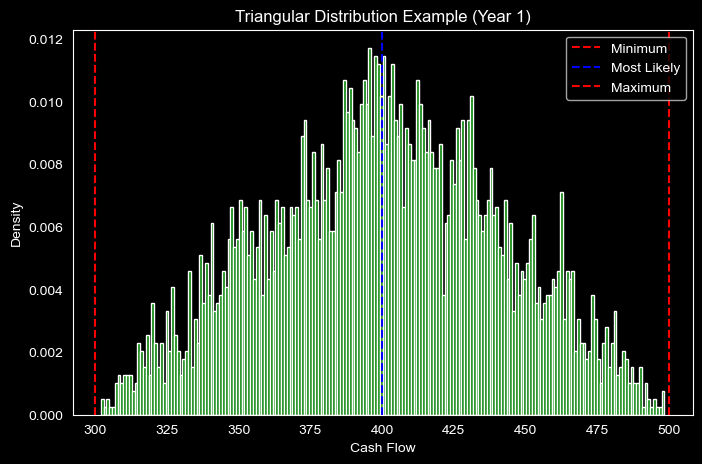

In [13]:
a1 = 300
m1 = 400
b1 = 500

samples = np.random.triangular(a1, m1, b1, size = 4000)

plt.figure(figsize=(8,5))
plt.hist(samples, bins=200, density=True, color="green")

plt.axvline(a1, linestyle="--", label = "Minimum", color = "red")
plt.axvline(m1, linestyle="--", label = "Most Likely", color = "blue")
plt.axvline(b1, linestyle="--", label = "Maximum", color = "red")

plt.title("Triangular Distribution Example (Year 1)")
plt.xlabel("Cash Flow")
plt.ylabel("Density")
plt.legend()
plt.grid(None)
plt.show()

### Why the histogram peak becomes clearer near the mode as sample size increases

A triangular distribution has a **mode** (most likely value), which is the point where its
probability density is highest.

A histogram is an **empirical estimator** of the distribution's Probability Density Function (PDF).
When the sample size \(n\) is small, the histogram is noisy: random sampling variation causes
some bins to be over- or under-represented.

As $(n)$ increases, the histogram becomes a more accurate approximation of the true PDF,
so the peak near the mode becomes clearer.

This can also be viewed through the lens of **error analysis / bias–variance tradeoff**:
- Small $(n)$ → high variance estimate ( noisy histogram )
- Large $(n)$ → lower variance estimate ( smoother histogram )

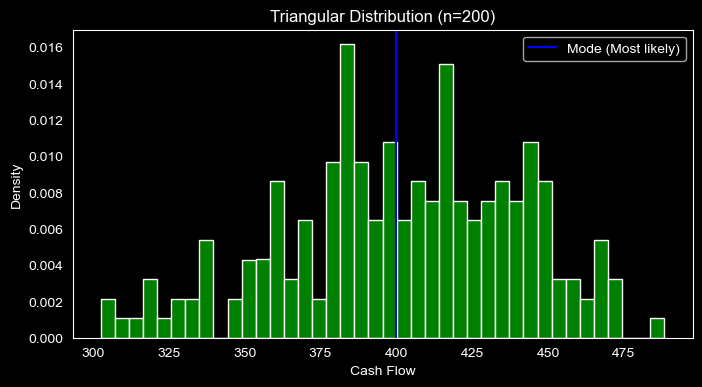

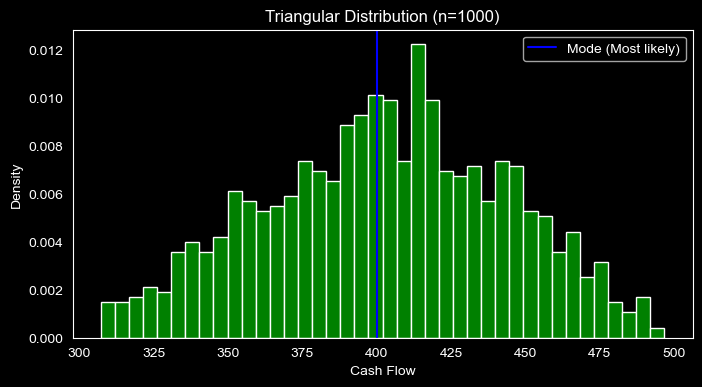

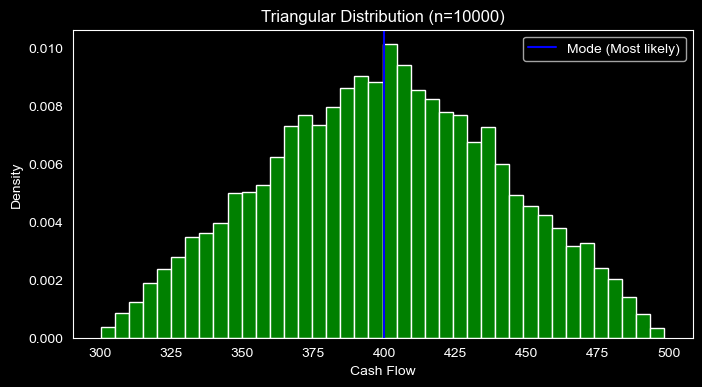

In [14]:
a1, m1, b1 = 300, 400, 500
sizes = [200, 1000, 10000]

for n in sizes:
    samples = np.random.triangular(a1, m1, b1, size=n)

    plt.figure(figsize=(8, 4))
    plt.hist(samples, bins=40, density=True, color="green")
    plt.axvline(m1, linestyle="-", label="Mode (Most likely)", color="blue")
    plt.title(f"Triangular Distribution (n={n})")
    plt.xlabel("Cash Flow")
    plt.ylabel("Density")
    plt.grid(None)
    plt.legend()
    plt.show()

## 6. Monte Carlo Simulation of Net Present Value

A single simulated cash flow path represents only one possible future.
However, investment decisions require understanding the entire distribution
of possible outcomes.

Monte Carlo simulation approximates the distribution of NPV by:

1. Repeatedly sampling cash flow scenarios.
2. Computing the NPV for each scenario.
3. Analyzing the resulting distribution of simulated NPVs.

As the number of simulations increases, the empirical distribution
approaches the true distribution.

### Monte Carlo Simulation Function

We now implement a function that:

• Generates many triangular cash flow scenarios
• Computes the NPV for each scenario
• Returns an array of simulated NPVs

In [15]:
def simulate_npv_triangular(n_sims, r, a, m, b):
    results = []

    for i in range(n_sims):
        cashflows = sample_triangular_cashflows(a, m, b)
        npv_value = npv_from_cashflows(cashflows, r)
        results.append(npv_value)

    return np.array(results)

### Running the Monte Carlo Simulation

We simulate 10 000 possible project outcomes.

In [16]:
r = 0.05
n_sims = 10000

npv_results = simulate_npv_triangular(n_sims, r, a, m, b)

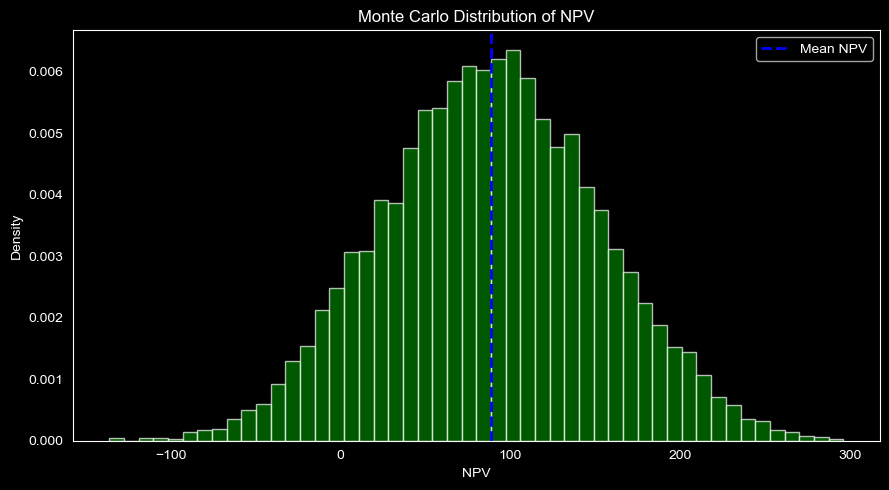

In [17]:
plt.figure(figsize=(9, 5))
plt.hist(npv_results, bins=50, density=True, alpha=0.7, color = "green")

mean_npv = np.mean(npv_results)
plt.axvline(mean_npv, linestyle="--", linewidth=2, label = "Mean NPV", color = "blue")

plt.title("Monte Carlo Distribution of NPV")
plt.xlabel("NPV")
plt.ylabel("Density")
plt.legend()
plt.grid(None)
plt.tight_layout()
plt.show()

### Interpretation of Monte Carlo Results

The histogram represents the empirical probability density of NPV
under the triangular cash flow assumptions.

The vertical line marks the estimated expected NPV.

The spread of the distribution reflects uncertainty in project outcomes.

### Risk Interpretation

• The mean NPV approximates the expected project value.
• The standard deviation measures dispersion (risk).
• The probability of loss estimates the likelihood that NPV < 0.

In [18]:
std_npv = np.std(npv_results)
prob_loss = np.mean(npv_results < 0)

print("Mean NPV:", round(mean_npv, 2))
print("Standard Deviation:", round(std_npv, 2))
print("Probability of Loss:", round(prob_loss, 4))

Mean NPV: 88.52
Standard Deviation: 63.95
Probability of Loss: 0.0858


### Empirical Cumulative Distribution Function (CDF)

While the histogram shows the shape of the distribution, the cumulative
distribution function (CDF) provides a probability-based view of outcomes.

The empirical CDF is defined as:


$$ F(x) = P(NPV \le x) $$

It represents the probability that the simulated NPV is less than or equal to a given value.

This visualization is particularly useful for:

- Estimating the probability of loss $(P(NPV < 0)$
- Identifying percentile thresholds (e.g., 5th or 95th percentile)
- Understanding downside and upside risk

As the number of simulations increases, the empirical CDF converges
to the true underlying distribution.

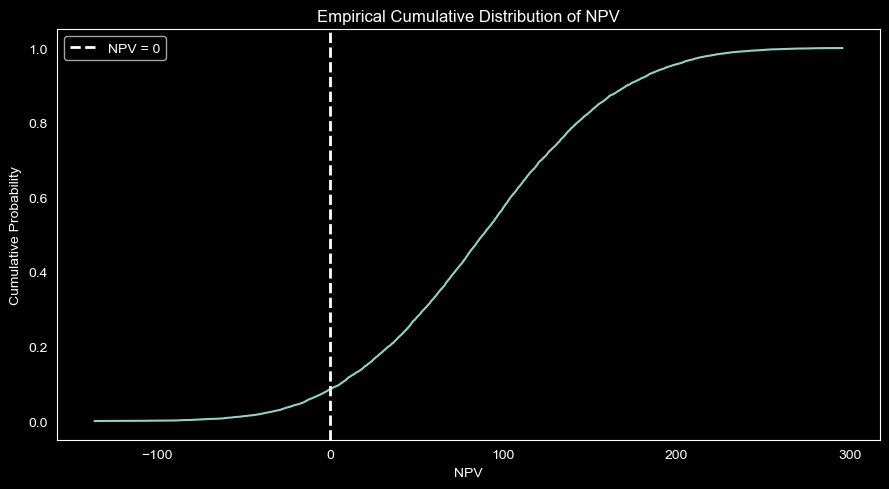

In [19]:
sorted_npvs = np.sort(npv_results)
cdf = np.arange(1, len(sorted_npvs) + 1) / len(sorted_npvs)

plt.figure(figsize=(9, 5))
plt.plot(sorted_npvs, cdf)
plt.axvline(0, linestyle="--", linewidth=2, label="NPV = 0")

plt.title("Empirical Cumulative Distribution of NPV")
plt.xlabel("NPV")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.tight_layout()
plt.grid(None)
plt.show()

### Boxplot: Compact Summary of Risk

While the histogram and CDF provide detailed distribution views,
the boxplot offers a compact summary of key statistical features.

The boxplot displays:

- The **median** (50th percentile)
- The **interquartile range (IQR)**: 25th to 75th percentile
- The overall spread of outcomes
- Potential extreme values (outliers)

In a financial context:

- The median represents the typical outcome.
- The interquartile range reflects the variability of central outcomes.
- The distance from the median to extreme values highlights tail risk.

This visualization provides a quick and intuitive overview of project risk.

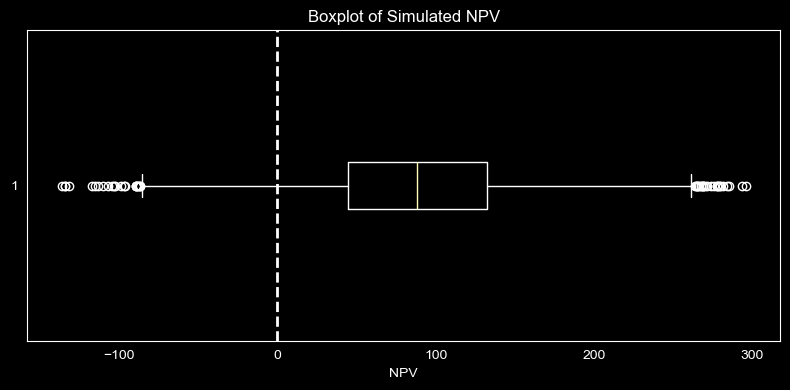

In [20]:
plt.figure(figsize=(8, 4))
plt.boxplot(npv_results, vert=False)
plt.axvline(0, linestyle="--", linewidth=2)
plt.title("Boxplot of Simulated NPV")
plt.xlabel("NPV")
plt.grid(None)
plt.tight_layout()
plt.show()

### Running Mean: Convergence of the Monte Carlo Estimate

To assess the stability of our simulation, we compute the running mean:


$$ \bar{X}_n = \frac{1}{n} \sum_{i=1}^{n} NPV_i $$

This shows how the estimated expected NPV evolves as more simulations
are accumulated.

According to the **Law of Large Numbers**, as the number of simulations \(n\) increases:

$$\bar{X}_n \rightarrow \mathbb{E}[NPV]$$

If the running mean stabilizes, this indicates that the Monte Carlo
estimate is converging and the simulation size is sufficient.

This visualization links numerical experimentation with probability theory.

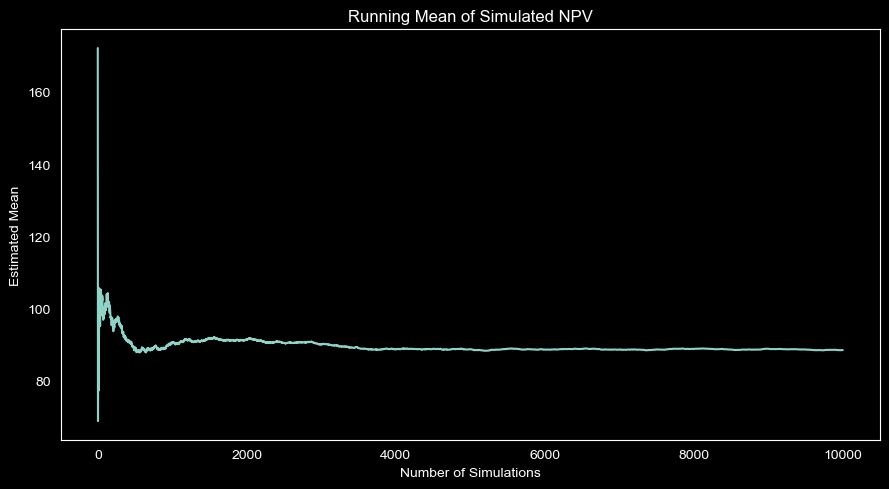

In [21]:
running_mean = np.cumsum(npv_results) / np.arange(1, len(npv_results) + 1)

plt.figure(figsize=(9, 5))
plt.plot(running_mean)
plt.title("Running Mean of Simulated NPV")
plt.xlabel("Number of Simulations")
plt.ylabel("Estimated Mean")
plt.grid(None)
plt.tight_layout()
plt.show()

## 7. Convergence and Statistical Stability Analysis

Monte Carlo simulation is a numerical approximation method.
Therefore, it is important to assess whether the estimates
stabilize as the number of simulations increases.

In this section, we examine convergence behavior and
downside risk characteristics in greater detail.

### Convergence of Estimated Mean NPV

We evaluate how the estimated mean NPV changes as the number
of simulations increases.

If the Monte Carlo method is stable, the estimate should
converge toward a constant value as simulation size grows.

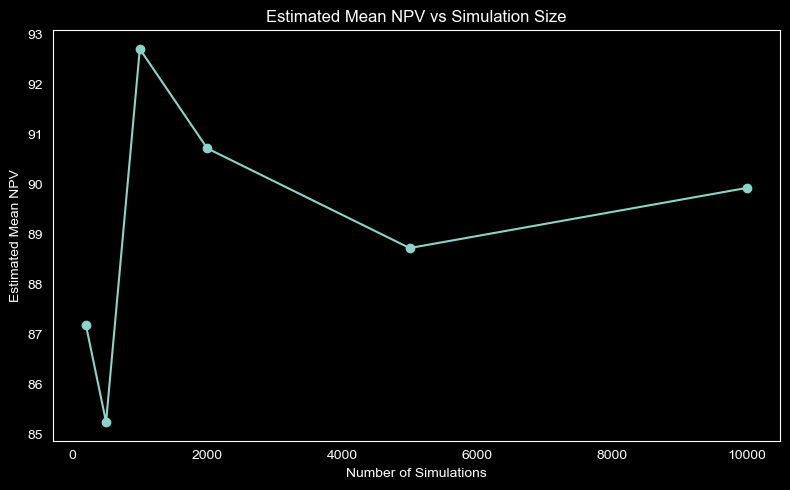

In [22]:
simulation_sizes = [200, 500, 1000, 2000, 5000, 10000]

estimated_means = []

for n in simulation_sizes:
    temp_results = simulate_npv_triangular(n, r, a, m, b)
    estimated_means.append(np.mean(temp_results))

plt.figure(figsize=(8, 5))
plt.plot(simulation_sizes, estimated_means, marker="o")
plt.title("Estimated Mean NPV vs Simulation Size")
plt.xlabel("Number of Simulations")
plt.ylabel("Estimated Mean NPV")
plt.tight_layout()
plt.grid(None)
plt.show()

#### Observation

The estimated mean becomes more stable as the number of simulations increases.

This behavior is consistent with the Law of Large Numbers,
which states that the sample mean converges to the expected value
as the sample size increases.

### Estimation Error Analysis

We measure how far smaller-sample estimates deviate
from the largest simulation estimate.

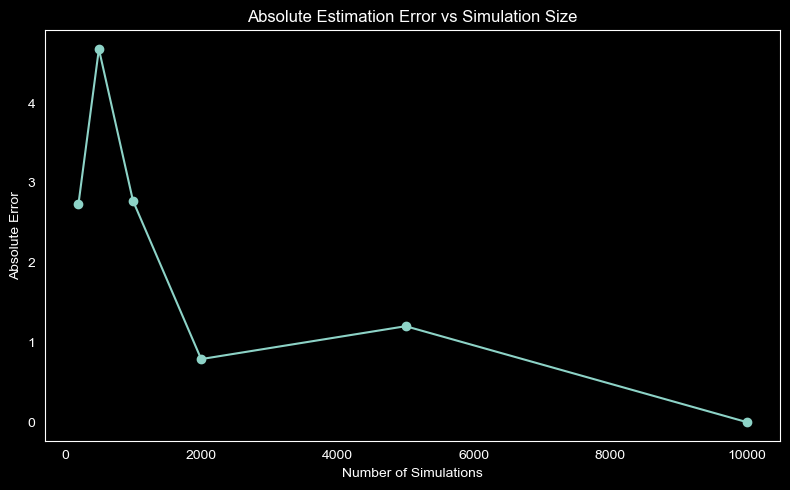

In [23]:
reference_mean = estimated_means[-1]

errors = [abs(m - reference_mean) for m in estimated_means]

plt.figure(figsize=(8, 5))
plt.plot(simulation_sizes, errors, marker="o")
plt.title("Absolute Estimation Error vs Simulation Size")
plt.xlabel("Number of Simulations")
plt.ylabel("Absolute Error")
plt.tight_layout()
plt.grid(None)
plt.show()

#### Observation

The estimation error decreases as simulation size increases.

This aligns with theoretical results from probability,
where estimation uncertainty decreases roughly at rate $(1/\sqrt{n})$.

### Visualizing Downside Risk

We highlight the region where NPV is negative.
This area represents value-destroying outcomes.

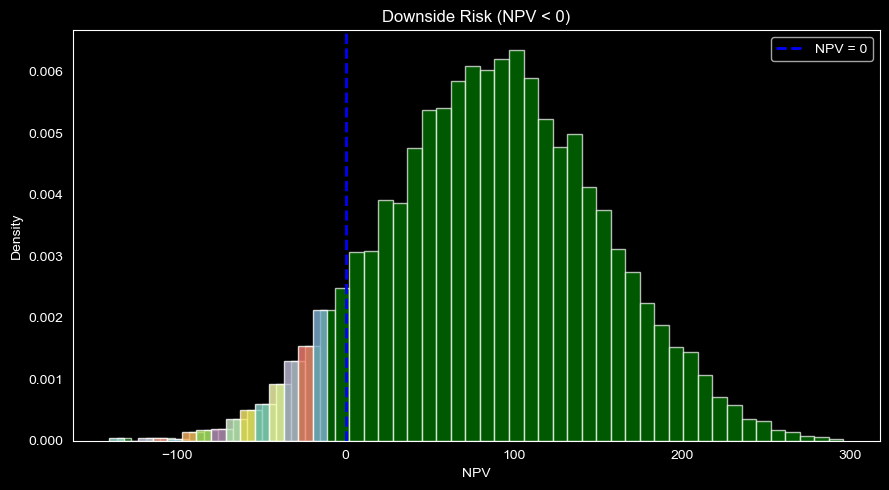

In [24]:
plt.figure(figsize=(9, 5))
counts, bins, _ = plt.hist(npv_results, bins=50, density=True, alpha=0.7, color = "green")

for i in range(len(bins)-1):
    if bins[i+1] < 0:
        plt.bar(bins[i], counts[i], width=bins[i+1]-bins[i], alpha=0.8,)

plt.axvline(0, linestyle="--", linewidth=2, label="NPV = 0", color = "blue")

plt.title("Downside Risk (NPV < 0)")
plt.xlabel("NPV")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.grid(None)
plt.show()

#### Observation

The shaded region represents outcomes where the project destroys value.

The relative size of this region corresponds to the probability of loss.

### Percentile-Based Risk View

We visualize selected percentiles of the NPV distribution.
This provides a scenario-based interpretation of risk.

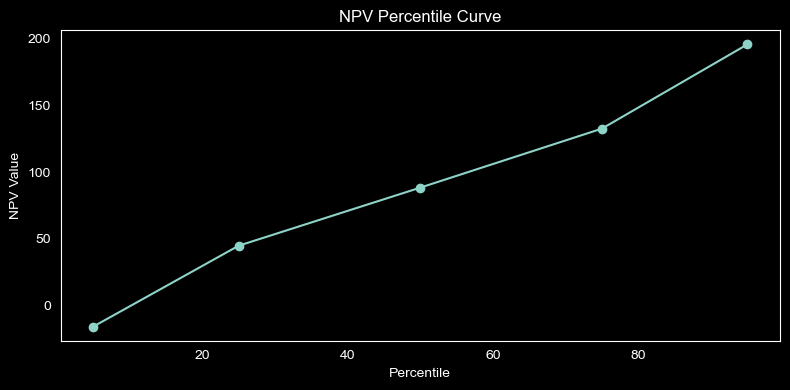

In [25]:
percentiles = [5, 25, 50, 75, 95]
values = np.percentile(npv_results, percentiles)

plt.figure(figsize=(8, 4))
plt.plot(percentiles, values, marker="o")
plt.title("NPV Percentile Curve")
plt.xlabel("Percentile")
plt.ylabel("NPV Value")
plt.tight_layout()
plt.grid(None)
plt.show()

#### Observation

Lower percentiles represent downside scenarios,
while upper percentiles represent favorable outcomes.

The slope of this curve reflects the spread of the distribution.

### Sensitivity Heatmap: Mean NPV vs Discount Rate and Uncertainty

We evaluate how the expected project value changes as:
- the discount rate $(r)$ varies
- cash flow uncertainty increases or decreases

For uncertainty scaling, we widen or narrow the triangular ranges around the mode.
The resulting heatmap shows the estimated mean NPV for each parameter combination.

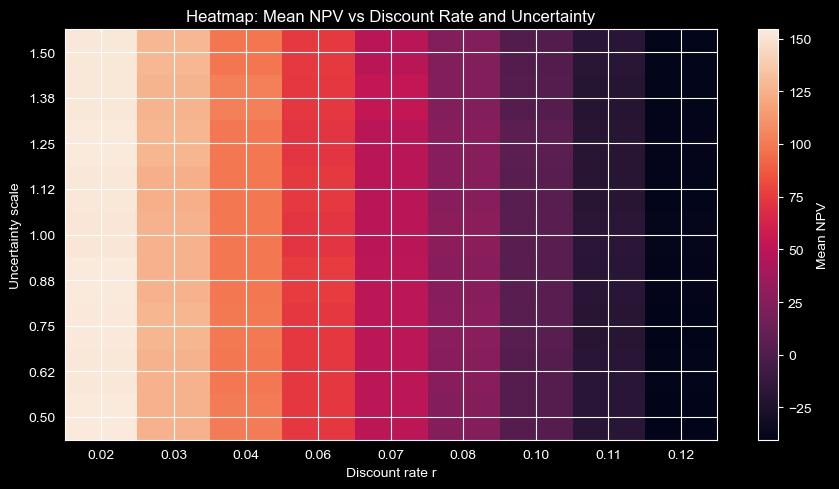

In [26]:
r_values = np.linspace(0.02, 0.12, 9)
unc_scales = np.linspace(0.5, 1.5, 9)
n_sims_heat = 3000

mean_grid = np.zeros((len(unc_scales), len(r_values)))

for i in range(len(unc_scales)):
    s = unc_scales[i]
    a_scaled = [a[0]]
    b_scaled = [b[0]]
    for t in range(1, len(m)):
        left = m[t] - s * (m[t] - a[t])
        right = m[t] + s * (b[t] - m[t])
        a_scaled.append(left)
        b_scaled.append(right)

    for j in range(len(r_values)):
        r_test = float(r_values[j])
        res = simulate_npv_triangular(n_sims_heat, r_test, a_scaled, m, b_scaled)
        mean_grid[i, j] = np.mean(res)

plt.figure(figsize=(9, 5))
plt.imshow(mean_grid, aspect="auto", origin="lower")
plt.colorbar(label="Mean NPV")
plt.xticks(np.arange(len(r_values)), [f"{x:.2f}" for x in r_values])
plt.yticks(np.arange(len(unc_scales)), [f"{x:.2f}" for x in unc_scales])
plt.title("Heatmap: Mean NPV vs Discount Rate and Uncertainty")
plt.xlabel("Discount rate r")
plt.ylabel("Uncertainty scale")
plt.tight_layout()
plt.show()

#### Observation

The heatmap highlights sensitivity to:
- discount rate (time value effect)
- uncertainty level (dispersion of outcomes)

This provides a multidimensional view of valuation risk, beyond a single histogram.

### Relationship Between Final Cash Flow and NPV

To better understand how uncertainty propagates through discounting,
we examine the relationship between the final year's cash flow
and the total project NPV.

This visualization helps identify:

- Sensitivity of NPV to terminal performance
- Strength of linear relationship
- Dispersion patterns

In [27]:
def simulate_npv_and_last_cf(n_sims, r, a, m, b):
    npv_values = []
    last_cashflows = []

    for i in range(n_sims):
        cashflows = sample_triangular_cashflows(a, m, b)
        npv_values.append(npv_from_cashflows(cashflows, r))
        last_cashflows.append(cashflows[-1])

    return np.array(npv_values), np.array(last_cashflows)

In [28]:
npv_vals, last_cf_vals = simulate_npv_and_last_cf(5000, r, a, m, b)

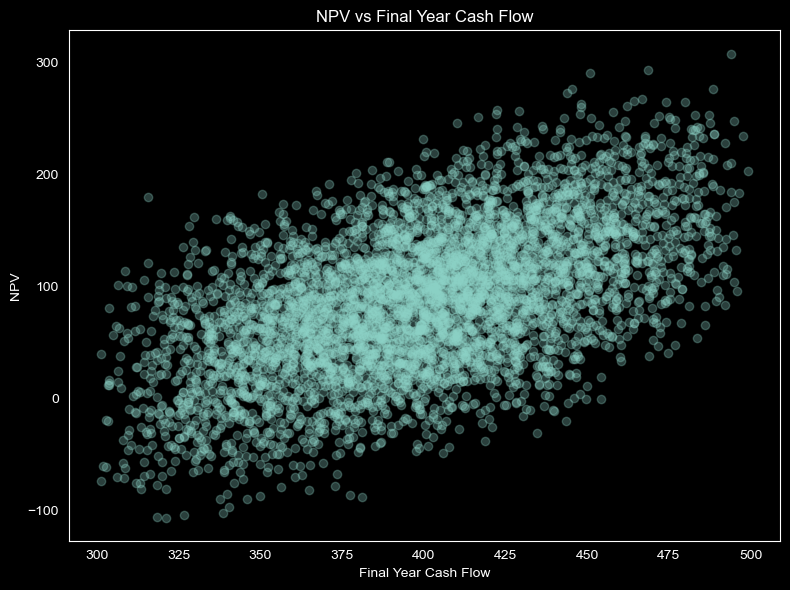

In [29]:
plt.figure(figsize=(8, 6))
plt.scatter(last_cf_vals, npv_vals, alpha=0.3)

plt.title("NPV vs Final Year Cash Flow")
plt.xlabel("Final Year Cash Flow")
plt.ylabel("NPV")
plt.tight_layout()
plt.grid(None)
plt.show()

#### Observation

A positive relationship is observed between the final cash flow
and total NPV.

However, due to discounting and contributions from earlier periods,
the relationship is not perfectly one-to-one.

This illustrates how uncertainty propagates through time
and is weighted by discount factors.

## 8. Correlated Cash Flows and Linear Algebra Formulation

So far, we assumed that cash flows in different periods are independent.
However, in reality, economic conditions often create correlation across years.

We define the cash flow vector:

$$ \mathbf{CF} = \begin{bmatrix} CF_0 \\ CF_1 \\ \vdots \\ CF_T \end{bmatrix} $$

Discounting can be written as a weight vector:

$$ w_t = \frac{1}{(1+r)^t} $$

$$ \mathbf{w} = \begin{bmatrix} w_0 \\ w_1 \\ \vdots \\ w_T \end{bmatrix} $$

The Net Present Value can then be written as:

$$ NPV = \mathbf{w}^T \mathbf{CF} $$

### Variance of NPV Under Correlation

If the cash flow vector has covariance matrix $(\Sigma)$,

$$ \Sigma = Cov(\mathbf{CF}) $$

then:

$$ Var(NPV) = Var(\mathbf{w}^T \mathbf{CF}) = \mathbf{w}^T \Sigma \mathbf{w} $$

This formula shows that correlation across years directly affects project risk.

### Computing Discount Weights

In [32]:
def discount_weights(r, T):
    w = []
    for t in range(T + 1):
        w.append(1 / (1 + r) ** t)
    return np.array(w)

T = len(a) - 1
w = discount_weights(r, T)
w

array([1.        , 0.95238095, 0.90702948, 0.8638376 ])

### Constructing the Covariance Matrix

To model correlation across years, we define a covariance matrix:

$$ \Sigma = Cov(\mathbf{CF}) $$

The covariance between two cash flows \(CF_i\) and \(CF_j\) is defined as:

$$ Cov(CF_i, CF_j) = \rho \sigma_i \sigma_j \quad \text{for } i \ne j $$

where:

• $(\sigma_i)$ = standard deviation of cash flow in year $(i)$
• $(\rho)$ = correlation coefficient between years

For the diagonal elements:

$$ Cov(CF_i, CF_i) = \sigma_i^2 $$

Thus, the covariance matrix takes the form:

$$ \Sigma = \begin{bmatrix} \sigma_0^2 & \rho\sigma_0\sigma_1 & \dots \\ \rho\sigma_1\sigma_0 & \sigma_1^2 & \dots \\ \vdots & \vdots & \ddots \end{bmatrix} $$

Interpretation:

• The diagonal elements measure individual cash flow variability.
• The off-diagonal elements measure how strongly cash flows move together.

If $(\rho > 0)$, good or bad years tend to occur together.
If $(\rho = 0)$, years are independent.
If $(\rho < 0)$, cash flows partially offset each other.

In [33]:
def build_cov_matrix(stds, rho):
    n = len(stds)
    Sigma = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i == j:
                Sigma[i, j] = stds[i] ** 2
            else:
                Sigma[i, j] = rho * stds[i] * stds[j]

    return Sigma

# example stds (0 for deterministic CF0)
stds = [0, 50, 50, 50]
rho = 0.5

Sigma = build_cov_matrix(stds, rho)
Sigma

array([[   0.,    0.,    0.,    0.],
       [   0., 2500., 1250., 1250.],
       [   0., 1250., 2500., 1250.],
       [   0., 1250., 1250., 2500.]])

### Analytic Variance of NPV

Using the vector formulation:

$$ NPV = \mathbf{w}^T \mathbf{CF} $$

The variance of NPV under correlation is:

$$ Var(NPV) = \mathbf{w}^T \Sigma \mathbf{w} $$

This expression shows that project risk depends on:

• The magnitude of discount weights $( \mathbf{w})$
• The variance of individual cash flows
• The correlation structure between years

The quadratic form $( \mathbf{w}^T \Sigma \mathbf{w}) $ captures
how discounting and correlation jointly determine total project risk.

In [36]:
var_analytic = w.T @ Sigma @ w
print("Analytic Variance of NPV:", var_analytic)
print("Analytic Std Dev:", np.sqrt(var_analytic))

Analytic Variance of NPV: 12365.03397419594
Analytic Std Dev: 111.19817432941936


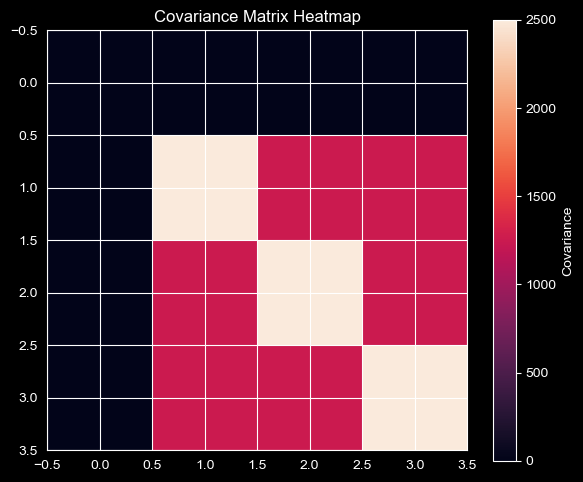

In [37]:
plt.figure(figsize=(6, 5))
plt.imshow(Sigma)
plt.colorbar(label="Covariance")
plt.title("Covariance Matrix Heatmap")
plt.tight_layout()
plt.show()

#### Observation

The analytic variance incorporates both:

• Individual cash flow volatility  (diagonal of $(\Sigma)$ )
• Cross-year correlation (off-diagonal terms)

If correlation increases, covariance terms contribute positively
to total variance, increasing project risk.

This demonstrates mathematically why correlated uncertainty
creates greater overall volatility.